<a href="https://colab.research.google.com/github/alyson-mei/ml_stuff/blob/main/practice/text_classification_practice_re.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [24]:
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn.utils.rnn import pad_sequence

from nltk.tokenize import WordPunctTokenizer

from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_yandex_ml_trainings/homeworks/hw04_bert_and_co/texts_holdout.json

--2025-04-05 20:40:38--  https://raw.githubusercontent.com/girafe-ai/ml-course/refs/heads/24f_yandex_ml_trainings/homeworks/hw04_bert_and_co/texts_holdout.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51581 (50K) [text/plain]
Saving to: ‘texts_holdout.json.1’

texts_holdout.json. 100%[===================>]  50.37K  --.-KB/s    in 0.009s  

2025-04-05 20:40:38 (5.72 MB/s) - ‘texts_holdout.json.1’ saved [51581/51581]



In [26]:
df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter = "\t",
    header = None
)
print(len(df))
df.head()

6920


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [27]:
N = 500
texts_train, y_train = df[0].values[:-N], list(map(int, df[1].values[:-N]))
texts_test, y_test = df[0].values[-N:], list(map(int, df[1].values[-N:]))

## Preprocessing

### Lang + auxiliary tokens

In [28]:
UNK, UNK_IDX = '<UNK>', 0
PAD, PAD_IDX = '<PAD>', 1

class Lang:
    def __init__(self, name, tokenize):
        self.name = name
        self.word2count = {}
        self.word2index = {UNK: UNK_IDX, PAD: PAD_IDX}
        self.index2word = {UNK_IDX: UNK, PAD_IDX: PAD}
        self.n_tokens = 2
        self.n_tokens_trimmed = self.n_tokens
        self.tokenize = tokenize

    def addSentence(self, sentence):
        for token in self.tokenize(sentence):
            self.addWord(token)

    def addWord(self, token):
        if token not in self.word2index:
            self.word2count[token] = 1
            self.word2index[token] = self.n_tokens
            self.index2word[self.n_tokens] = token
            self.n_tokens += 1
            self.n_tokens_trimmed += 1
        else:
            self.word2count[token] += 1

    def trimDict(self, min_freq = 3):
        for token in self.word2count:
            if self.word2count[token] < min_freq:
                self.word2index[token] = UNK_IDX
                self.n_tokens_trimmed -= 1

    def normalizeWord2Index(self):
        idx = 2
        word2index = {UNK: UNK_IDX, PAD: PAD_IDX}
        index2word = {UNK_IDX: UNK, PAD_IDX: PAD}
        for token in self.word2count:
            if self.word2index[token] != UNK_IDX:
                word2index[token] = idx
                index2word[idx] = token
                idx += 1
            else:
                word2index[token] = UNK_IDX
        self.word2index = word2index
        self.index2word = index2word

In [29]:
tokenizer = WordPunctTokenizer()
tokenize = tokenizer.tokenize
lang = Lang("src", tokenize)

for sent in tqdm(texts_train):
     lang.addSentence(sent)
for sent in tqdm(texts_test):
     lang.addSentence(sent)

lang.trimDict(min_freq = 2)
lang.normalizeWord2Index()
print(f'\nInitial vocab size: {lang.n_tokens}, trimmed vocab size: {lang.n_tokens_trimmed}')

VOC_SIZE = lang.n_tokens_trimmed

100%|██████████| 500/500 [00:00<00:00, 80693.83it/s]


Initial vocab size: 13829, trimmed vocab size: 7200


### Indexing

In [30]:
def indexing(sentence):
    tokens = tokenizer.tokenize(sentence.lower())
    return [lang.word2index.get(token, UNK_IDX) for token in tokens]

def translate(indexed):
    return [lang.index2word.get(idx, UNK) for idx in indexed]

In [31]:
sentence = texts_train[0]

indexed = indexing(sentence)
translated = translate(indexed)

print(f'{sentence},\n {indexed},\n {translated}')

a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films,
 [2, 3, 4, 5, 6, 7, 8, 9, 0, 10, 11, 6, 12, 13, 6, 0, 14, 15],
 ['a', 'stirring', ',', 'funny', 'and', 'finally', 'transporting', 're', '<UNK>', 'of', 'beauty', 'and', 'the', 'beast', 'and', '<UNK>', 'horror', 'films']


In [32]:
def indexingData(data, test = False):
    indexed_data = []
    return [indexing(text) for text in data]

In [33]:
indexed_train_data = indexingData(texts_train)
indexed_test_data = indexingData(texts_test)

In [34]:
for i in range(3):
    print(f"\nSample {i+1}:")
    print(f"Label: {y_train[i]}")
    print(f"Original: {texts_train[i]}")
    print(f"Indexed: {indexed_train_data[i]}")
    print(f"Translated: {' '.join(translate(indexed_train_data[i]))}")


Sample 1:
Label: 1
Original: a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
Indexed: [2, 3, 4, 5, 6, 7, 8, 9, 0, 10, 11, 6, 12, 13, 6, 0, 14, 15]
Translated: a stirring , funny and finally transporting re <UNK> of beauty and the beast and <UNK> horror films

Sample 2:
Label: 0
Original: apparently reassembled from the cutting room floor of any given daytime soap
Indexed: [16, 0, 17, 12, 18, 19, 20, 10, 21, 22, 23, 24]
Translated: apparently <UNK> from the cutting room floor of any given daytime soap

Sample 3:
Label: 0
Original: they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes
Indexed: [25, 0, 26, 27, 28, 29, 30, 31, 32, 33, 34, 2, 35, 36, 4, 37, 38, 39, 4, 40, 25, 0, 41, 12, 42, 43, 44, 45, 10, 46, 47, 48, 6, 49, 50, 51, 0, 52]
Translated: they <UNK> their

### Making batches

In [35]:
BATCH_SIZE = 256

from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

def simple_collate(batch):
    inputs = [torch.tensor(x[0], dtype = torch.long) for x in batch]
    labels = torch.tensor([x[1] for x in batch])

    padded_inputs = pad_sequence(inputs, batch_first = True, padding_value = PAD_IDX)
    return padded_inputs, labels

train_data = list(zip(indexed_train_data, y_train))
test_data = list(zip(indexed_test_data, y_test))

train_loader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    collate_fn = simple_collate
)

test_loader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False,
    collate_fn = simple_collate
)

next(iter(train_loader))

(tensor([[ 321, 1979,  403,  ...,    1,    1,    1],
         [  53,   54,   12,  ...,    1,    1,    1],
         [ 160,   30,   68,  ...,    1,    1,    1],
         ...,
         [ 219,  871, 2942,  ...,    1,    1,    1],
         [   0,   30,   68,  ...,    1,    1,    1],
         [6025,    4,   12,  ...,    1,    1,    1]]),
 tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
         1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
         0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
         0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
         1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 

### Train

In [36]:
def train(
    model,
    train_loader,
    test_loader,
    epochs = 30,
    device = DEVICE,
    model_name = "GRU"
    ):

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_epoch(model, train_loader)
        val_loss, val_acc = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:} | Val Loss: {val_loss}")
        print(f"Train Acc: {train_acc} | Val Acc: {val_acc}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training/Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Acc')
    plt.plot(val_acc_history, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Training/Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def train_epoch(model, loader):
    model.train()
    correct = 0
    total_loss = 0.
    total_samples = 0  # Добавляем счетчик примеров

    for input, target in loader:
        input, target = input.to(DEVICE), target.long().to(DEVICE)
        batch_size = input.size(0)  # Получаем размер текущего батча
        optimizer.zero_grad()
        output = model(input)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size  # Умножаем на размер батча
        preds = output.argmax(dim=1)
        correct += (preds == target).sum().item()
        total_samples += batch_size  # Учитываем все примеры

    return total_loss / total_samples, correct / total_samples  # Делим на общее число примеров

def evaluate(model, loader):
    model.eval()
    correct = 0
    total_loss = 0.
    total_samples = 0

    with torch.no_grad():
        for input, target in loader:
            input, target = input.to(DEVICE), target.to(DEVICE)
            batch_size = input.size(0)
            output = model(input)

            loss = criterion(output, target)
            total_loss += loss.item() * batch_size

            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total_samples += batch_size

    return total_loss / total_samples, correct / total_samples

### GRU model

In [37]:
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, voc_size, emb_dim = 128, hidden_dim = 256, n_layers = 1):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(
            input_size = emb_dim,
            hidden_size = hidden_dim,
            num_layers = n_layers,
            batch_first = True,
            bidirectional = False
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)  # (batch_size, seq_len, emb_dim)
        _, h_n = self.gru(x)   # h_n: (n_layers, batch_size, hidden_dim)
        last_hidden = h_n[-1]
        return self.fc(self.dropout(last_hidden))  # (batch_size,)

In [50]:
model = GRUClassifier(VOC_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

  2%|▏         | 1/50 [00:00<00:17,  2.75it/s]


Epoch 1/50:
Train Loss: 0.6933770740143607 | Val Loss: 0.691441623210907
Train Acc: 0.5169781931464175 | Val Acc: 0.522


  4%|▍         | 2/50 [00:00<00:15,  3.00it/s]


Epoch 2/50:
Train Loss: 0.6921080149965494 | Val Loss: 0.6916835579872131
Train Acc: 0.5133956386292835 | Val Acc: 0.518


  6%|▌         | 3/50 [00:00<00:15,  3.07it/s]


Epoch 3/50:
Train Loss: 0.6909660577031311 | Val Loss: 0.6920666785240174
Train Acc: 0.5246105919003116 | Val Acc: 0.52


  8%|▊         | 4/50 [00:01<00:14,  3.09it/s]


Epoch 4/50:
Train Loss: 0.691805161493961 | Val Loss: 0.6919458274841308
Train Acc: 0.523208722741433 | Val Acc: 0.52


 10%|█         | 5/50 [00:01<00:14,  3.13it/s]


Epoch 5/50:
Train Loss: 0.6903029913100127 | Val Loss: 0.6916014528274537
Train Acc: 0.5158878504672897 | Val Acc: 0.522


 12%|█▏        | 6/50 [00:01<00:13,  3.14it/s]


Epoch 6/50:
Train Loss: 0.6894309554887338 | Val Loss: 0.6929019522666932
Train Acc: 0.5269470404984423 | Val Acc: 0.486


 14%|█▍        | 7/50 [00:02<00:13,  3.13it/s]


Epoch 7/50:
Train Loss: 0.6911010005021021 | Val Loss: 0.6921382761001587
Train Acc: 0.5121495327102804 | Val Acc: 0.52


 16%|█▌        | 8/50 [00:02<00:13,  3.15it/s]


Epoch 8/50:
Train Loss: 0.6903413746958581 | Val Loss: 0.6919572305679321
Train Acc: 0.5236760124610592 | Val Acc: 0.52


 18%|█▊        | 9/50 [00:02<00:13,  3.14it/s]


Epoch 9/50:
Train Loss: 0.689978393550231 | Val Loss: 0.6921563458442688
Train Acc: 0.5210280373831776 | Val Acc: 0.512


 20%|██        | 10/50 [00:03<00:12,  3.15it/s]


Epoch 10/50:
Train Loss: 0.6786338821749821 | Val Loss: 0.6851094522476197
Train Acc: 0.5713395638629284 | Val Acc: 0.59


 22%|██▏       | 11/50 [00:03<00:12,  3.16it/s]


Epoch 11/50:
Train Loss: 0.6884355160306176 | Val Loss: 0.6913099412918091
Train Acc: 0.5292834890965732 | Val Acc: 0.52


 24%|██▍       | 12/50 [00:03<00:12,  3.16it/s]


Epoch 12/50:
Train Loss: 0.6857641066346213 | Val Loss: 0.6922376194000244
Train Acc: 0.5161993769470405 | Val Acc: 0.494


 26%|██▌       | 13/50 [00:04<00:11,  3.15it/s]


Epoch 13/50:
Train Loss: 0.6731433753283967 | Val Loss: 0.6649698204994202
Train Acc: 0.5495327102803739 | Val Acc: 0.596


 28%|██▊       | 14/50 [00:04<00:11,  3.16it/s]


Epoch 14/50:
Train Loss: 0.6069479602890966 | Val Loss: 0.7200756783485412
Train Acc: 0.6813084112149532 | Val Acc: 0.656


 30%|███       | 15/50 [00:04<00:11,  3.16it/s]


Epoch 15/50:
Train Loss: 0.510205100834184 | Val Loss: 0.6667734479904175
Train Acc: 0.7696261682242991 | Val Acc: 0.672


 32%|███▏      | 16/50 [00:05<00:11,  3.04it/s]


Epoch 16/50:
Train Loss: 0.40755892306844765 | Val Loss: 0.6015807709693909
Train Acc: 0.8297507788161994 | Val Acc: 0.698


 34%|███▍      | 17/50 [00:05<00:11,  2.95it/s]


Epoch 17/50:
Train Loss: 0.32060088166195283 | Val Loss: 0.6651310834884644
Train Acc: 0.8789719626168224 | Val Acc: 0.706


 36%|███▌      | 18/50 [00:05<00:11,  2.89it/s]


Epoch 18/50:
Train Loss: 0.2497954969465547 | Val Loss: 0.6698409419059753
Train Acc: 0.9121495327102803 | Val Acc: 0.726


 38%|███▊      | 19/50 [00:06<00:10,  2.83it/s]


Epoch 19/50:
Train Loss: 0.18650735323767054 | Val Loss: 0.835067545413971
Train Acc: 0.9375389408099688 | Val Acc: 0.724


 40%|████      | 20/50 [00:06<00:10,  2.82it/s]


Epoch 20/50:
Train Loss: 0.1327403758521949 | Val Loss: 0.8793581075668335
Train Acc: 0.9621495327102804 | Val Acc: 0.714


 42%|████▏     | 21/50 [00:06<00:10,  2.83it/s]


Epoch 21/50:
Train Loss: 0.09740487117076589 | Val Loss: 0.9827617554664612
Train Acc: 0.9718068535825545 | Val Acc: 0.724


 44%|████▍     | 22/50 [00:07<00:09,  2.91it/s]


Epoch 22/50:
Train Loss: 0.07735632411276812 | Val Loss: 1.1444612703323365
Train Acc: 0.9753894080996884 | Val Acc: 0.734


 46%|████▌     | 23/50 [00:07<00:09,  2.96it/s]


Epoch 23/50:
Train Loss: 0.057245301445394844 | Val Loss: 1.2188169498443604
Train Acc: 0.9833333333333333 | Val Acc: 0.734


 48%|████▊     | 24/50 [00:07<00:08,  3.00it/s]


Epoch 24/50:
Train Loss: 0.05867508293544392 | Val Loss: 1.0780535082817078
Train Acc: 0.9830218068535825 | Val Acc: 0.732


 50%|█████     | 25/50 [00:08<00:08,  3.04it/s]


Epoch 25/50:
Train Loss: 0.035624899018288955 | Val Loss: 1.3326629352569581
Train Acc: 0.9884735202492212 | Val Acc: 0.734


 52%|█████▏    | 26/50 [00:08<00:07,  3.07it/s]


Epoch 26/50:
Train Loss: 0.024357577381986323 | Val Loss: 1.2732823486328124
Train Acc: 0.9929906542056075 | Val Acc: 0.742


 54%|█████▍    | 27/50 [00:08<00:07,  3.06it/s]


Epoch 27/50:
Train Loss: 0.025527301739402278 | Val Loss: 1.2362215938568115
Train Acc: 0.9926791277258566 | Val Acc: 0.72


 56%|█████▌    | 28/50 [00:09<00:07,  3.09it/s]


Epoch 28/50:
Train Loss: 0.022732008459783418 | Val Loss: 1.3974547863006592
Train Acc: 0.9940809968847352 | Val Acc: 0.734


 58%|█████▊    | 29/50 [00:09<00:06,  3.10it/s]


Epoch 29/50:
Train Loss: 0.02154928690919252 | Val Loss: 1.4359525556564332
Train Acc: 0.9934579439252337 | Val Acc: 0.74


 60%|██████    | 30/50 [00:09<00:06,  3.11it/s]


Epoch 30/50:
Train Loss: 0.008164261211351002 | Val Loss: 1.5398981447219848
Train Acc: 0.9978193146417446 | Val Acc: 0.746


 62%|██████▏   | 31/50 [00:10<00:06,  3.11it/s]


Epoch 31/50:
Train Loss: 0.01320244574809093 | Val Loss: 1.7198063678741455
Train Acc: 0.9959501557632399 | Val Acc: 0.724


 64%|██████▍   | 32/50 [00:10<00:05,  3.10it/s]


Epoch 32/50:
Train Loss: 0.013923463049980107 | Val Loss: 1.7757738132476806
Train Acc: 0.997196261682243 | Val Acc: 0.732


 66%|██████▌   | 33/50 [00:10<00:05,  3.12it/s]


Epoch 33/50:
Train Loss: 0.00816544860871973 | Val Loss: 2.1083504180908204
Train Acc: 0.9981308411214953 | Val Acc: 0.728


 68%|██████▊   | 34/50 [00:11<00:05,  3.11it/s]


Epoch 34/50:
Train Loss: 0.014696194846589246 | Val Loss: 1.5017374591827393
Train Acc: 0.9968847352024922 | Val Acc: 0.728


 70%|███████   | 35/50 [00:11<00:04,  3.12it/s]


Epoch 35/50:
Train Loss: 0.005337385407966674 | Val Loss: 1.9669003219604493
Train Acc: 0.9989096573208722 | Val Acc: 0.744


 72%|███████▏  | 36/50 [00:11<00:04,  3.13it/s]


Epoch 36/50:
Train Loss: 0.0167188684351603 | Val Loss: 1.5415591297149658
Train Acc: 0.9950155763239875 | Val Acc: 0.752


 74%|███████▍  | 37/50 [00:12<00:04,  3.13it/s]


Epoch 37/50:
Train Loss: 0.010581901813480087 | Val Loss: 1.5966718702316285
Train Acc: 0.997196261682243 | Val Acc: 0.742


 76%|███████▌  | 38/50 [00:12<00:03,  3.11it/s]


Epoch 38/50:
Train Loss: 0.0042502407769373736 | Val Loss: 1.8530256872177124
Train Acc: 0.9992211838006231 | Val Acc: 0.744


 78%|███████▊  | 39/50 [00:12<00:03,  3.12it/s]


Epoch 39/50:
Train Loss: 0.004392877683432256 | Val Loss: 1.7382606220245362
Train Acc: 0.9990654205607477 | Val Acc: 0.738


 80%|████████  | 40/50 [00:13<00:03,  3.13it/s]


Epoch 40/50:
Train Loss: 0.005252281714352631 | Val Loss: 1.5958301725387574
Train Acc: 0.9989096573208722 | Val Acc: 0.758


 82%|████████▏ | 41/50 [00:13<00:02,  3.13it/s]


Epoch 41/50:
Train Loss: 0.0066712544427320036 | Val Loss: 1.9860204229354859
Train Acc: 0.99797507788162 | Val Acc: 0.736


 84%|████████▍ | 42/50 [00:13<00:02,  3.12it/s]


Epoch 42/50:
Train Loss: 0.01539264302874837 | Val Loss: 1.9296861066818238
Train Acc: 0.9954828660436137 | Val Acc: 0.726


 86%|████████▌ | 43/50 [00:14<00:02,  3.12it/s]


Epoch 43/50:
Train Loss: 0.018958546169032562 | Val Loss: 1.4279313373565674
Train Acc: 0.9962616822429906 | Val Acc: 0.722


 88%|████████▊ | 44/50 [00:14<00:01,  3.12it/s]


Epoch 44/50:
Train Loss: 0.013897637789524988 | Val Loss: 1.6744347372055053
Train Acc: 0.9959501557632399 | Val Acc: 0.728


 90%|█████████ | 45/50 [00:14<00:01,  3.11it/s]


Epoch 45/50:
Train Loss: 0.005459832980346828 | Val Loss: 1.9012256965637206
Train Acc: 0.9982866043613707 | Val Acc: 0.722


 92%|█████████▏| 46/50 [00:14<00:01,  3.12it/s]


Epoch 46/50:
Train Loss: 0.002084086683609253 | Val Loss: 2.088676294326782
Train Acc: 0.9995327102803738 | Val Acc: 0.72


 94%|█████████▍| 47/50 [00:15<00:00,  3.14it/s]


Epoch 47/50:
Train Loss: 0.005745075803324058 | Val Loss: 1.9406584482192992
Train Acc: 0.9984423676012462 | Val Acc: 0.724


 96%|█████████▌| 48/50 [00:15<00:00,  3.12it/s]


Epoch 48/50:
Train Loss: 0.002604323602462843 | Val Loss: 1.9744472332000733
Train Acc: 0.9990654205607477 | Val Acc: 0.728


 98%|█████████▊| 49/50 [00:15<00:00,  3.12it/s]


Epoch 49/50:
Train Loss: 0.000376292861576665 | Val Loss: 2.2521342363357544
Train Acc: 1.0 | Val Acc: 0.732


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Epoch 50/50:
Train Loss: 0.00011124605703895848 | Val Loss: 2.3394362716674806
Train Acc: 1.0 | Val Acc: 0.73


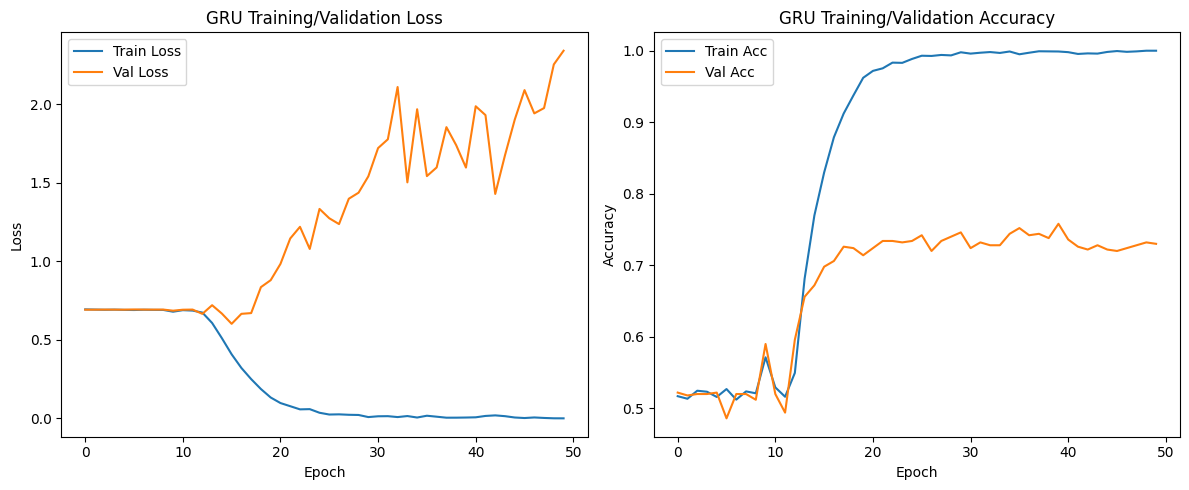

In [51]:
train(model, train_loader, test_loader, epochs = 50)

### Transformer model

In [40]:
class TransformerClassifier(nn.Module):
    def __init__(self, voc_size, emb_dim = 128, nhead = 4, num_layers = 2, dropout = 0.2):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, emb_dim, padding_idx = PAD_IDX)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = emb_dim,
            nhead = nhead,
            dropout = dropout,
            batch_first = True,
            activation = 'gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)
        self.fc = nn.Linear(emb_dim, 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1)
        return self.fc(x)

In [45]:
model = TransformerClassifier(
    voc_size=VOC_SIZE,
    emb_dim = 256,
    nhead = 8,
    num_layers = 4
).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

  1%|          | 1/100 [00:04<06:36,  4.01s/it]


Epoch 1/100:
Train Loss: 0.6848672615033444 | Val Loss: 0.6621023764610291
Train Acc: 0.5661993769470405 | Val Acc: 0.6


  2%|▏         | 2/100 [00:07<06:28,  3.96s/it]


Epoch 2/100:
Train Loss: 0.6536674565243944 | Val Loss: 0.6629420127868653
Train Acc: 0.6105919003115264 | Val Acc: 0.604


  3%|▎         | 3/100 [00:11<06:22,  3.94s/it]


Epoch 3/100:
Train Loss: 0.6369723326691957 | Val Loss: 0.6743710980415344
Train Acc: 0.6333333333333333 | Val Acc: 0.58


  4%|▍         | 4/100 [00:15<06:17,  3.93s/it]


Epoch 4/100:
Train Loss: 0.6297138231937016 | Val Loss: 0.6676629257202148
Train Acc: 0.6422118380062305 | Val Acc: 0.642


  5%|▌         | 5/100 [00:19<06:14,  3.94s/it]


Epoch 5/100:
Train Loss: 0.6143315899037869 | Val Loss: 0.6584418439865112
Train Acc: 0.6621495327102803 | Val Acc: 0.638


  6%|▌         | 6/100 [00:23<06:11,  3.96s/it]


Epoch 6/100:
Train Loss: 0.6116657307214826 | Val Loss: 0.641594747543335
Train Acc: 0.6627725856697819 | Val Acc: 0.65


  7%|▋         | 7/100 [00:27<06:07,  3.95s/it]


Epoch 7/100:
Train Loss: 0.588468091658714 | Val Loss: 0.665397349357605
Train Acc: 0.682398753894081 | Val Acc: 0.664


  8%|▊         | 8/100 [00:31<06:04,  3.96s/it]


Epoch 8/100:
Train Loss: 0.5725141679015116 | Val Loss: 0.6529690127372741
Train Acc: 0.6968847352024922 | Val Acc: 0.652


  9%|▉         | 9/100 [00:35<06:02,  3.98s/it]


Epoch 9/100:
Train Loss: 0.571577548720755 | Val Loss: 0.6661532492637634
Train Acc: 0.6950155763239876 | Val Acc: 0.63


 10%|█         | 10/100 [00:39<05:59,  3.99s/it]


Epoch 10/100:
Train Loss: 0.5642206825199899 | Val Loss: 0.6721745362281799
Train Acc: 0.711214953271028 | Val Acc: 0.652


 11%|█         | 11/100 [00:43<05:55,  4.00s/it]


Epoch 11/100:
Train Loss: 0.5388544663833309 | Val Loss: 0.6917795586585999
Train Acc: 0.7219626168224299 | Val Acc: 0.63


 12%|█▏        | 12/100 [00:47<05:48,  3.97s/it]


Epoch 12/100:
Train Loss: 0.5307313800043778 | Val Loss: 0.693340705871582
Train Acc: 0.7274143302180686 | Val Acc: 0.648


 13%|█▎        | 13/100 [00:51<05:45,  3.98s/it]


Epoch 13/100:
Train Loss: 0.511603912906112 | Val Loss: 0.7287847809791564
Train Acc: 0.7390965732087228 | Val Acc: 0.648


 14%|█▍        | 14/100 [00:55<05:43,  3.99s/it]


Epoch 14/100:
Train Loss: 0.49826307014512866 | Val Loss: 0.7066475095748901
Train Acc: 0.7540498442367601 | Val Acc: 0.63


 15%|█▌        | 15/100 [00:59<05:37,  3.97s/it]


Epoch 15/100:
Train Loss: 0.4855986958352205 | Val Loss: 0.6905608034133911
Train Acc: 0.7602803738317757 | Val Acc: 0.654


 16%|█▌        | 16/100 [01:03<05:31,  3.94s/it]


Epoch 16/100:
Train Loss: 0.4688543486075238 | Val Loss: 0.6932904043197632
Train Acc: 0.7730529595015576 | Val Acc: 0.656


 17%|█▋        | 17/100 [01:07<05:26,  3.94s/it]


Epoch 17/100:
Train Loss: 0.4596261964037411 | Val Loss: 0.7330181293487549
Train Acc: 0.7727414330218069 | Val Acc: 0.672


 18%|█▊        | 18/100 [01:11<05:22,  3.93s/it]


Epoch 18/100:
Train Loss: 0.46109411330237937 | Val Loss: 0.7519061098098755
Train Acc: 0.7747663551401869 | Val Acc: 0.654


 19%|█▉        | 19/100 [01:15<05:17,  3.92s/it]


Epoch 19/100:
Train Loss: 0.4184048867671289 | Val Loss: 0.8058524107933045
Train Acc: 0.8070093457943925 | Val Acc: 0.636


 20%|██        | 20/100 [01:19<05:13,  3.92s/it]


Epoch 20/100:
Train Loss: 0.4105649669222371 | Val Loss: 0.8121285367012024
Train Acc: 0.8042056074766355 | Val Acc: 0.646


 21%|██        | 21/100 [01:23<05:10,  3.93s/it]


Epoch 21/100:
Train Loss: 0.38937182023517813 | Val Loss: 0.8347749657630921
Train Acc: 0.823208722741433 | Val Acc: 0.656


 22%|██▏       | 22/100 [01:26<05:05,  3.92s/it]


Epoch 22/100:
Train Loss: 0.3682754021195979 | Val Loss: 0.8504167342185974
Train Acc: 0.8311526479750779 | Val Acc: 0.674


 23%|██▎       | 23/100 [01:30<05:03,  3.94s/it]


Epoch 23/100:
Train Loss: 0.3557206316157665 | Val Loss: 0.842349579334259
Train Acc: 0.8389408099688473 | Val Acc: 0.676


 24%|██▍       | 24/100 [01:34<04:58,  3.93s/it]


Epoch 24/100:
Train Loss: 0.33686369962038654 | Val Loss: 0.8496718740463257
Train Acc: 0.85 | Val Acc: 0.67


 25%|██▌       | 25/100 [01:38<04:53,  3.92s/it]


Epoch 25/100:
Train Loss: 0.3176777372850436 | Val Loss: 0.9247551164627075
Train Acc: 0.8601246105919003 | Val Acc: 0.656


 26%|██▌       | 26/100 [01:42<04:50,  3.93s/it]


Epoch 26/100:
Train Loss: 0.29085461935521656 | Val Loss: 0.9234728531837464
Train Acc: 0.8755451713395639 | Val Acc: 0.67


 27%|██▋       | 27/100 [01:46<04:47,  3.94s/it]


Epoch 27/100:
Train Loss: 0.2756544605965184 | Val Loss: 0.9457179737091065
Train Acc: 0.8825545171339564 | Val Acc: 0.674


 28%|██▊       | 28/100 [01:50<04:43,  3.94s/it]


Epoch 28/100:
Train Loss: 0.25820004065460134 | Val Loss: 1.0505523262023926
Train Acc: 0.8909657320872274 | Val Acc: 0.668


 29%|██▉       | 29/100 [01:54<04:40,  3.96s/it]


Epoch 29/100:
Train Loss: 0.2385306255468327 | Val Loss: 1.1278806505203247
Train Acc: 0.9 | Val Acc: 0.658


 30%|███       | 30/100 [01:58<04:36,  3.95s/it]


Epoch 30/100:
Train Loss: 0.28041041149899965 | Val Loss: 0.9075670056343078
Train Acc: 0.8794392523364486 | Val Acc: 0.68


 31%|███       | 31/100 [02:02<04:33,  3.96s/it]


Epoch 31/100:
Train Loss: 0.2575537995943028 | Val Loss: 0.977579282283783
Train Acc: 0.8897196261682243 | Val Acc: 0.668


 32%|███▏      | 32/100 [02:06<04:28,  3.95s/it]


Epoch 32/100:
Train Loss: 0.20021492681027944 | Val Loss: 1.008058135986328
Train Acc: 0.920404984423676 | Val Acc: 0.674


 33%|███▎      | 33/100 [02:10<04:23,  3.94s/it]


Epoch 33/100:
Train Loss: 0.1834684159246932 | Val Loss: 1.068893138885498
Train Acc: 0.9274143302180685 | Val Acc: 0.676


 34%|███▍      | 34/100 [02:14<04:19,  3.94s/it]


Epoch 34/100:
Train Loss: 0.17125976509022936 | Val Loss: 1.1152337617874146
Train Acc: 0.9292834890965732 | Val Acc: 0.678


 35%|███▌      | 35/100 [02:18<04:15,  3.94s/it]


Epoch 35/100:
Train Loss: 0.17052223539426692 | Val Loss: 1.193645733833313
Train Acc: 0.9313084112149532 | Val Acc: 0.688


 36%|███▌      | 36/100 [02:22<04:11,  3.93s/it]


Epoch 36/100:
Train Loss: 0.16147662668584664 | Val Loss: 1.1882727394104005
Train Acc: 0.9338006230529595 | Val Acc: 0.674


 37%|███▋      | 37/100 [02:26<04:07,  3.92s/it]


Epoch 37/100:
Train Loss: 0.1662411422094452 | Val Loss: 1.2136598091125488
Train Acc: 0.9309968847352025 | Val Acc: 0.686


 38%|███▊      | 38/100 [02:29<04:02,  3.92s/it]


Epoch 38/100:
Train Loss: 0.14276196340627018 | Val Loss: 1.2790279417037964
Train Acc: 0.9436137071651091 | Val Acc: 0.674


 39%|███▉      | 39/100 [02:33<03:58,  3.92s/it]


Epoch 39/100:
Train Loss: 0.13676669871510003 | Val Loss: 1.2911881866455077
Train Acc: 0.9479750778816199 | Val Acc: 0.688


 40%|████      | 40/100 [02:37<03:55,  3.93s/it]


Epoch 40/100:
Train Loss: 0.13222311134000433 | Val Loss: 1.3359313764572143
Train Acc: 0.9501557632398754 | Val Acc: 0.694


 41%|████      | 41/100 [02:41<03:51,  3.93s/it]


Epoch 41/100:
Train Loss: 0.11410299608269213 | Val Loss: 1.3636478672027588
Train Acc: 0.9552959501557632 | Val Acc: 0.688


 42%|████▏     | 42/100 [02:45<03:48,  3.94s/it]


Epoch 42/100:
Train Loss: 0.14383974563666965 | Val Loss: 1.2958666315078735
Train Acc: 0.944392523364486 | Val Acc: 0.69


 43%|████▎     | 43/100 [02:49<03:44,  3.93s/it]


Epoch 43/100:
Train Loss: 0.11579407656164926 | Val Loss: 1.2144617395401
Train Acc: 0.9545171339563863 | Val Acc: 0.696


 44%|████▍     | 44/100 [02:53<03:39,  3.93s/it]


Epoch 44/100:
Train Loss: 0.09576518015930215 | Val Loss: 1.3504179525375366
Train Acc: 0.9638629283489096 | Val Acc: 0.702


 45%|████▌     | 45/100 [02:57<03:36,  3.93s/it]


Epoch 45/100:
Train Loss: 0.08941318045407998 | Val Loss: 1.402632791519165
Train Acc: 0.967601246105919 | Val Acc: 0.698


 46%|████▌     | 46/100 [03:01<03:31,  3.91s/it]


Epoch 46/100:
Train Loss: 0.08118390461366125 | Val Loss: 1.3671642427444457
Train Acc: 0.9721183800623053 | Val Acc: 0.722


 47%|████▋     | 47/100 [03:05<03:26,  3.91s/it]


Epoch 47/100:
Train Loss: 0.08957982836204155 | Val Loss: 1.3880378065109253
Train Acc: 0.9674454828660436 | Val Acc: 0.694


 48%|████▊     | 48/100 [03:09<03:23,  3.92s/it]


Epoch 48/100:
Train Loss: 0.07639973718800648 | Val Loss: 1.4983761491775514
Train Acc: 0.9713395638629283 | Val Acc: 0.706


 49%|████▉     | 49/100 [03:13<03:19,  3.91s/it]


Epoch 49/100:
Train Loss: 0.10542660227445798 | Val Loss: 1.4159621677398682
Train Acc: 0.9615264797507788 | Val Acc: 0.686


 50%|█████     | 50/100 [03:17<03:16,  3.92s/it]


Epoch 50/100:
Train Loss: 0.08876214077771638 | Val Loss: 1.4085303888320924
Train Acc: 0.9658878504672898 | Val Acc: 0.686


 51%|█████     | 51/100 [03:20<03:12,  3.93s/it]


Epoch 51/100:
Train Loss: 0.07302013934703074 | Val Loss: 1.4756431951522828
Train Acc: 0.9714953271028037 | Val Acc: 0.7


 52%|█████▏    | 52/100 [03:24<03:09,  3.95s/it]


Epoch 52/100:
Train Loss: 0.06664577158301419 | Val Loss: 1.5001866636276244
Train Acc: 0.9757009345794393 | Val Acc: 0.694


 53%|█████▎    | 53/100 [03:28<03:05,  3.94s/it]


Epoch 53/100:
Train Loss: 0.0613527786601741 | Val Loss: 1.463075117111206
Train Acc: 0.9778816199376947 | Val Acc: 0.706


 54%|█████▍    | 54/100 [03:32<03:00,  3.93s/it]


Epoch 54/100:
Train Loss: 0.06584793750742143 | Val Loss: 1.5378460521697999
Train Acc: 0.9781931464174455 | Val Acc: 0.694


 55%|█████▌    | 55/100 [03:36<02:56,  3.93s/it]


Epoch 55/100:
Train Loss: 0.05202013528978342 | Val Loss: 1.5422886915206908
Train Acc: 0.9820872274143302 | Val Acc: 0.706


 56%|█████▌    | 56/100 [03:40<02:53,  3.94s/it]


Epoch 56/100:
Train Loss: 0.06599521589497354 | Val Loss: 1.5432167911529542
Train Acc: 0.9750778816199377 | Val Acc: 0.702


 57%|█████▋    | 57/100 [03:44<02:49,  3.94s/it]


Epoch 57/100:
Train Loss: 0.04860876909111891 | Val Loss: 1.5893883771896362
Train Acc: 0.9822429906542056 | Val Acc: 0.702


 58%|█████▊    | 58/100 [03:48<02:45,  3.93s/it]


Epoch 58/100:
Train Loss: 0.060441443349620635 | Val Loss: 1.5380719480514526
Train Acc: 0.9789719626168224 | Val Acc: 0.706


 59%|█████▉    | 59/100 [03:52<02:41,  3.95s/it]


Epoch 59/100:
Train Loss: 0.052698419435744714 | Val Loss: 1.5607000894546508
Train Acc: 0.9814641744548287 | Val Acc: 0.692


 60%|██████    | 60/100 [03:56<02:37,  3.94s/it]


Epoch 60/100:
Train Loss: 0.05461175063874491 | Val Loss: 1.611304102897644
Train Acc: 0.9806853582554517 | Val Acc: 0.698


 61%|██████    | 61/100 [04:00<02:33,  3.94s/it]


Epoch 61/100:
Train Loss: 0.07993161951502165 | Val Loss: 1.485744870185852
Train Acc: 0.969626168224299 | Val Acc: 0.696


 62%|██████▏   | 62/100 [04:04<02:29,  3.94s/it]


Epoch 62/100:
Train Loss: 0.05069578548550977 | Val Loss: 1.519492395401001
Train Acc: 0.9828660436137072 | Val Acc: 0.694


 63%|██████▎   | 63/100 [04:08<02:25,  3.93s/it]


Epoch 63/100:
Train Loss: 0.053268610002513615 | Val Loss: 1.5983093366622925
Train Acc: 0.9802180685358255 | Val Acc: 0.704


 64%|██████▍   | 64/100 [04:12<02:21,  3.92s/it]


Epoch 64/100:
Train Loss: 0.05355651456851083 | Val Loss: 1.540159278869629
Train Acc: 0.9819314641744549 | Val Acc: 0.7


 65%|██████▌   | 65/100 [04:16<02:17,  3.92s/it]


Epoch 65/100:
Train Loss: 0.041926425747643006 | Val Loss: 1.5975134754180909
Train Acc: 0.9858255451713396 | Val Acc: 0.698


 66%|██████▌   | 66/100 [04:19<02:13,  3.93s/it]


Epoch 66/100:
Train Loss: 0.04530213794633282 | Val Loss: 1.591336130142212
Train Acc: 0.9833333333333333 | Val Acc: 0.708


 67%|██████▋   | 67/100 [04:23<02:09,  3.93s/it]


Epoch 67/100:
Train Loss: 0.042631237856707194 | Val Loss: 1.592101674079895
Train Acc: 0.9839563862928349 | Val Acc: 0.712


 68%|██████▊   | 68/100 [04:27<02:06,  3.94s/it]


Epoch 68/100:
Train Loss: 0.03854755933086077 | Val Loss: 1.567099871635437
Train Acc: 0.9850467289719627 | Val Acc: 0.716


 69%|██████▉   | 69/100 [04:31<02:02,  3.94s/it]


Epoch 69/100:
Train Loss: 0.02925564866524619 | Val Loss: 1.625692400932312
Train Acc: 0.990031152647975 | Val Acc: 0.698


 70%|███████   | 70/100 [04:35<01:58,  3.93s/it]


Epoch 70/100:
Train Loss: 0.04524805185115226 | Val Loss: 1.6734527988433838
Train Acc: 0.9858255451713396 | Val Acc: 0.704


 71%|███████   | 71/100 [04:39<01:54,  3.95s/it]


Epoch 71/100:
Train Loss: 0.03871511119240866 | Val Loss: 1.7575498552322388
Train Acc: 0.9876947040498443 | Val Acc: 0.702


 72%|███████▏  | 72/100 [04:43<01:50,  3.94s/it]


Epoch 72/100:
Train Loss: 0.03730110353862757 | Val Loss: 1.6383803901672362
Train Acc: 0.9850467289719627 | Val Acc: 0.71


 73%|███████▎  | 73/100 [04:47<01:46,  3.95s/it]


Epoch 73/100:
Train Loss: 0.06220993613389051 | Val Loss: 1.5549158420562743
Train Acc: 0.979595015576324 | Val Acc: 0.712


 74%|███████▍  | 74/100 [04:51<01:42,  3.96s/it]


Epoch 74/100:
Train Loss: 0.060399536663126724 | Val Loss: 1.5330195789337158
Train Acc: 0.9788161993769471 | Val Acc: 0.716


 75%|███████▌  | 75/100 [04:55<01:38,  3.95s/it]


Epoch 75/100:
Train Loss: 0.04567276835731721 | Val Loss: 1.5427750759124756
Train Acc: 0.9848909657320872 | Val Acc: 0.714


 76%|███████▌  | 76/100 [04:59<01:34,  3.94s/it]


Epoch 76/100:
Train Loss: 0.03565514567844871 | Val Loss: 1.6212974710464478
Train Acc: 0.9875389408099688 | Val Acc: 0.702


 77%|███████▋  | 77/100 [05:03<01:30,  3.95s/it]


Epoch 77/100:
Train Loss: 0.028621407392843863 | Val Loss: 1.6167417650222777
Train Acc: 0.990031152647975 | Val Acc: 0.72


 78%|███████▊  | 78/100 [05:07<01:26,  3.94s/it]


Epoch 78/100:
Train Loss: 0.029588639795362394 | Val Loss: 1.5840888109207154
Train Acc: 0.9892523364485981 | Val Acc: 0.732


 79%|███████▉  | 79/100 [05:11<01:22,  3.94s/it]


Epoch 79/100:
Train Loss: 0.028217530455817454 | Val Loss: 1.5783549013137816
Train Acc: 0.9904984423676012 | Val Acc: 0.72


 80%|████████  | 80/100 [05:15<01:18,  3.94s/it]


Epoch 80/100:
Train Loss: 0.03735536550783851 | Val Loss: 1.6710182571411132
Train Acc: 0.9873831775700934 | Val Acc: 0.728


 81%|████████  | 81/100 [05:19<01:15,  3.95s/it]


Epoch 81/100:
Train Loss: 0.033525569757847026 | Val Loss: 1.5802520790100099
Train Acc: 0.9881619937694704 | Val Acc: 0.736


 82%|████████▏ | 82/100 [05:23<01:10,  3.94s/it]


Epoch 82/100:
Train Loss: 0.02617331728849827 | Val Loss: 1.570017683982849
Train Acc: 0.9914330218068536 | Val Acc: 0.732


 83%|████████▎ | 83/100 [05:26<01:06,  3.92s/it]


Epoch 83/100:
Train Loss: 0.039797238364954975 | Val Loss: 1.6425479011535644
Train Acc: 0.9856697819314642 | Val Acc: 0.714


 84%|████████▍ | 84/100 [05:30<01:02,  3.93s/it]


Epoch 84/100:
Train Loss: 0.040867844999207883 | Val Loss: 1.635730128288269
Train Acc: 0.9864485981308411 | Val Acc: 0.712


 85%|████████▌ | 85/100 [05:34<00:58,  3.92s/it]


Epoch 85/100:
Train Loss: 0.0336406492599144 | Val Loss: 1.735088493347168
Train Acc: 0.9895638629283489 | Val Acc: 0.71


 86%|████████▌ | 86/100 [05:38<00:55,  3.93s/it]


Epoch 86/100:
Train Loss: 0.031364244129798866 | Val Loss: 1.7123213939666748
Train Acc: 0.9903426791277259 | Val Acc: 0.712


 87%|████████▋ | 87/100 [05:42<00:51,  3.93s/it]


Epoch 87/100:
Train Loss: 0.04789376515790681 | Val Loss: 1.6056403188705444
Train Acc: 0.981619937694704 | Val Acc: 0.716


 88%|████████▊ | 88/100 [05:46<00:47,  3.93s/it]


Epoch 88/100:
Train Loss: 0.030155138369661254 | Val Loss: 1.6081084661483764
Train Acc: 0.9897196261682243 | Val Acc: 0.714


 89%|████████▉ | 89/100 [05:50<00:43,  3.93s/it]


Epoch 89/100:
Train Loss: 0.029362718957676507 | Val Loss: 1.7173621139526367
Train Acc: 0.9903426791277259 | Val Acc: 0.706


 90%|█████████ | 90/100 [05:54<00:39,  3.94s/it]


Epoch 90/100:
Train Loss: 0.026803926366883276 | Val Loss: 1.6622810440063476
Train Acc: 0.9906542056074766 | Val Acc: 0.716


 91%|█████████ | 91/100 [05:58<00:35,  3.93s/it]


Epoch 91/100:
Train Loss: 0.052306697409124206 | Val Loss: 1.5766078214645385
Train Acc: 0.9827102803738318 | Val Acc: 0.712


 92%|█████████▏| 92/100 [06:02<00:31,  3.95s/it]


Epoch 92/100:
Train Loss: 0.03253534127641875 | Val Loss: 1.5926500749588013
Train Acc: 0.9886292834890966 | Val Acc: 0.712


 93%|█████████▎| 93/100 [06:06<00:27,  3.95s/it]


Epoch 93/100:
Train Loss: 0.023275550698565545 | Val Loss: 1.7234641494750977
Train Acc: 0.9917445482866044 | Val Acc: 0.706


 94%|█████████▍| 94/100 [06:10<00:23,  3.94s/it]


Epoch 94/100:
Train Loss: 0.02708755589073605 | Val Loss: 1.673637794494629
Train Acc: 0.9904984423676012 | Val Acc: 0.716


 95%|█████████▌| 95/100 [06:14<00:19,  3.93s/it]


Epoch 95/100:
Train Loss: 0.02282667132152529 | Val Loss: 1.6875710973739624
Train Acc: 0.9914330218068536 | Val Acc: 0.742


 96%|█████████▌| 96/100 [06:18<00:15,  3.93s/it]


Epoch 96/100:
Train Loss: 0.025239541478646554 | Val Loss: 1.7199910125732423
Train Acc: 0.9901869158878505 | Val Acc: 0.716


 97%|█████████▋| 97/100 [06:22<00:11,  3.93s/it]


Epoch 97/100:
Train Loss: 0.025307404437911844 | Val Loss: 1.824244089126587
Train Acc: 0.9920560747663552 | Val Acc: 0.71


 98%|█████████▊| 98/100 [06:26<00:07,  3.93s/it]


Epoch 98/100:
Train Loss: 0.07741197443268381 | Val Loss: 1.6505035963058472
Train Acc: 0.9719626168224299 | Val Acc: 0.716


 99%|█████████▉| 99/100 [06:29<00:03,  3.91s/it]


Epoch 99/100:
Train Loss: 0.044537927734888974 | Val Loss: 1.6556392288208008
Train Acc: 0.9845794392523365 | Val Acc: 0.704


100%|██████████| 100/100 [06:33<00:00,  3.94s/it]


Epoch 100/100:
Train Loss: 0.031934693346316476 | Val Loss: 1.6584172410964966
Train Acc: 0.9887850467289719 | Val Acc: 0.716


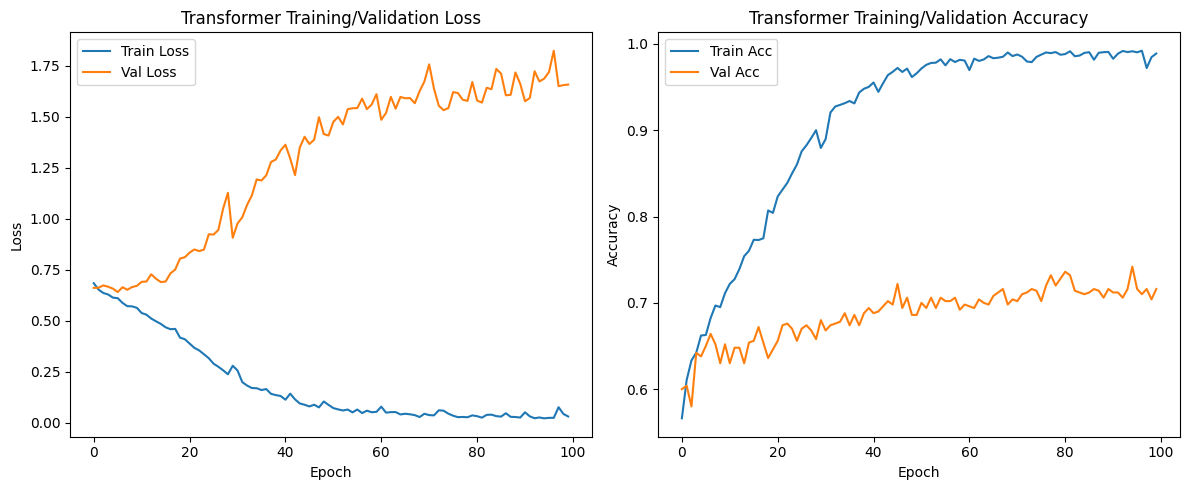

In [46]:
train(
    model,
    train_loader,
    test_loader,
    epochs = 100,
    device = DEVICE,
    model_name = "Transformer"
)